In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..

# Introduction

<font size="4">
The report follow up the investiagtion on <a href="https://arxiv.org/abs/2212.10076">"Out-of-sample scoring and automatic selection of causal estimators"</a>. 

In summary , the purpose of the paper is to develop a metrics that can be use to compare the performance of different Instrument Variable models (Causal estimator) in out of sample setting. The preliminary result from the paper shows that the three proposed metrics are well perform in the case of RCT expirement or un-confounding case, however, when confoundng is included in the causual model, those metrics start to degenerated.

The following figure from the paper shows the differences between the un-confounding and confounding case on those metrics.

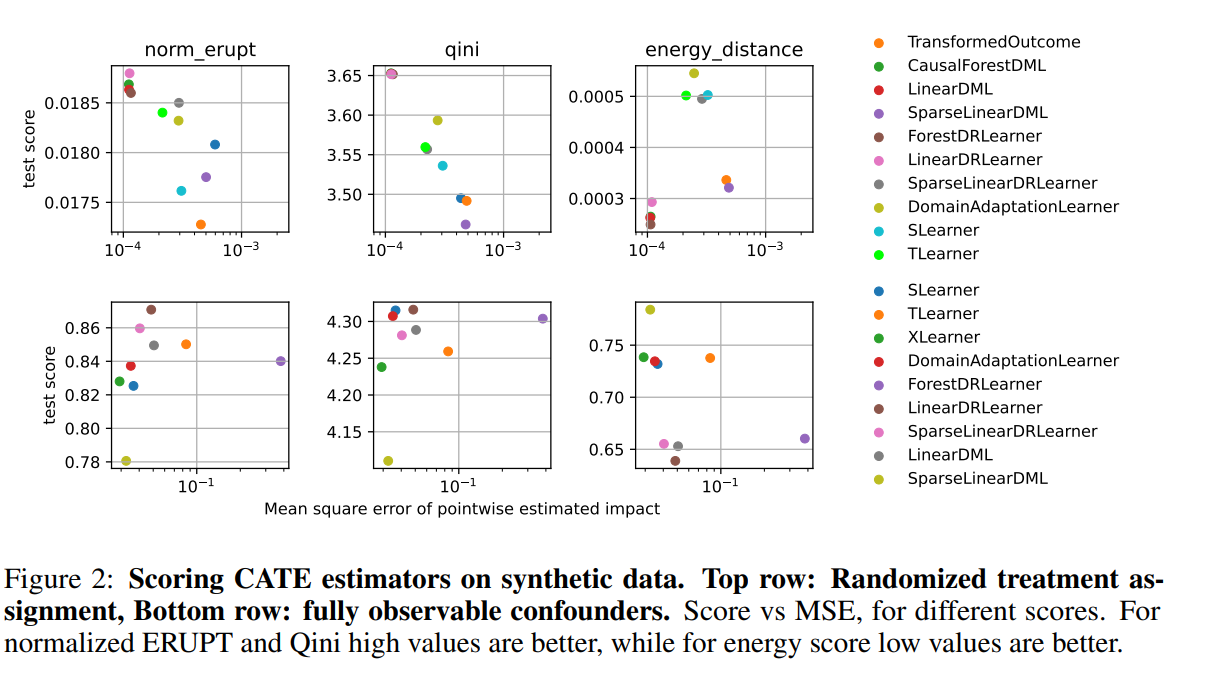

source(<a href="https://arxiv.org/abs/2212.10076">"Out-of-sample scoring and automatic selection of causal estimators"</a>)
</font>

# Experiment Setup (Original Paper)
<font size="4">
The paper have perform the study on both synthetic data and real world data. Here we are focus on the synthetics data setting.

In the synthetics data setting where true effect is accessable, the pape try to build association between the MSE of predicted and true effect with the metric score in order to access the how well is the out of sample metric reflect the effect estimation. 

The following diagram shows roughtly how the auto-causality pipeline is set. 

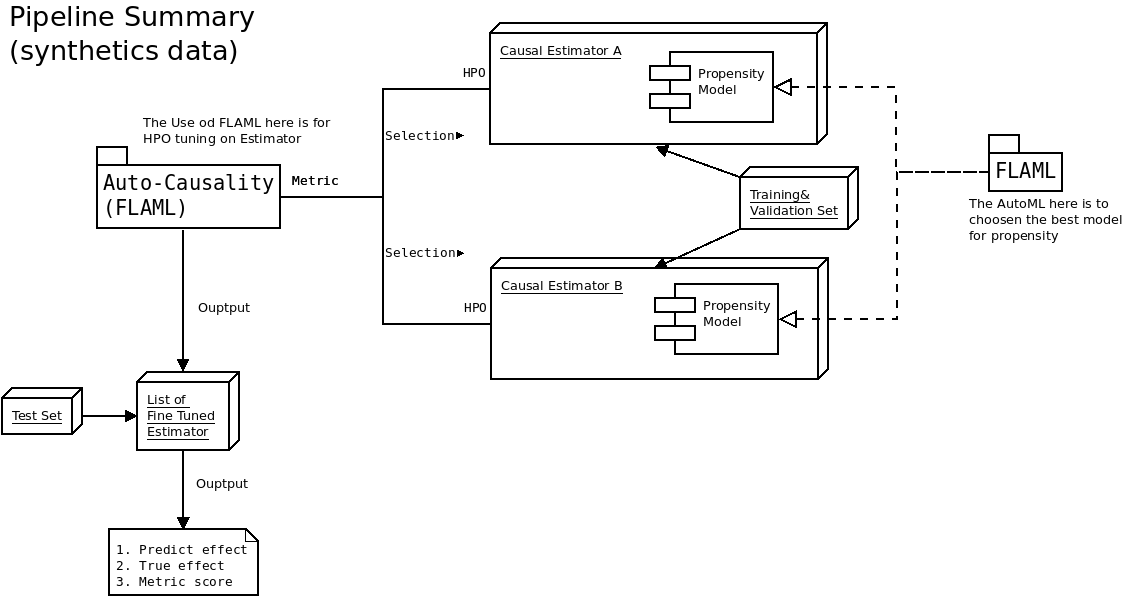
</font>

## Experiment for this project 
<font size="4">
This project is aim to focus on the case where confounding is include in causal model (Model B.) with extending the propensity function class in compare to the original paper which using the default setting of FLAML. 

The reason to extend the propensity class is that most of causal estimator use propensity model as a prior belief on calculating the causal influence of interest, so the performance of propensity model is a critical factor affecting the result of effect estimation.

The following table list out different model that used in this project in compare to the paper: 

|Paper(FLAML Default) | This project (Custom Model) |
|:------:|:-----------:|
|lgbm   | Gaussian Naive Bayesian  |
|rf     | Decision Tree |
|catboost|SVM|
|xgboost| Logistic Regression|
|extra_tree| MLP|
</font>
### Experiment Setup

#### Data set:
<font size="4">
5 datasets were generated using the generate_synthetic_data function provided in the library with the setting list in the table:

  | Properties| Setting|
  |:---------|:-----|   
  |Sampe Size | 10000 |
  |Test Size  | 0.33  |
  |Confounding| True|
  |Linear Confouning| True|
  | Add Noise | True|
</font>
#### Steps:
<font size="4">
Those generated dataset were used in feeding the base case and the extended case which result in 5 experiment runs.

The result are plotted in the same manner with metrci vs the MSE of effect 
</font>

# Result plot on Association between Metric Score and MSE [BaseCase Vs AutoML(GBN,DT,LR,SVM,MLP)]  :
<font size="4">
From the below plot on the left for the base case, those plots confirm the result of the paper that those 3 metrics failed to associate with the MSE of effect.

On the other hand, the right hand side for the AutoML with extended propensity class shows some evidence that the metric norm_erupt did shows the expected trend on the scoring, which higher norm_erupt score is associated with lower MSE. 

However, the above observation is challenged by the experiment Run 2 and 3, which on both plots, there is 1 exception causal estimator with higher MSE that is rank with roughtly the same score for those estimator with much lower MSE.

The resulting plot also discover a interesting pattern that didn't shows in the paper which the energy_distance metric consistenly bais on SLearner,Tlearner and XLearner which they are all from MetaLearner Causal estimator.
 </font>

In [3]:
#model=['BaseCase','AutoML_All','AutoML_SVM','AutoML_MLP','AutoML_GNB','AutoML_LR']
#out_dir=["./NoteBook_preprocessWithinClass_NewData/","./Super_NewData/",'./SVM_NewData/','./MLP_NewData/','./NaiveBayesian_NewData/','./LR_NewData/']
model=['BaseCase','AutoML_All']
out_dir=["./result/NoteBook_preprocessWithinClass_NewData/","./result/Super_NewData/"]
subtitle=["Run1","Run2","Run3","Run4","Run5"]
filename_out = "synthetic_observational_cate" 
metrics = ["norm_erupt", "qini","energy_distance"]

In [4]:
scorelist={}
prscore={}
values={}
for o in range(len(out_dir)):
    scorelist[model[o]]=[]
    prscore[model[o]]={}
    values[model[o]]={}
    for s in range(len(subtitle)):
        data=[]
        prscore[model[o]][f'{s+1}']={}
        values[model[o]][f'{s+1}']={}
        for m in range(len(metrics)):
            with open(f"{out_dir[o]}{filename_out}_{metrics[m]}_run_{s+1}.pkl","rb") as f:
                results = pickle.load(f)
            prscore[model[o]][f'{s+1}'][metrics[m]]=[]
            values[model[o]][f'{s+1}'][metrics[m]]=[]
            for i in results["scores_per_estimator"].items():
                temp=[]
                
                temp.append(i[0])
                temp.append(s+1)
                cate_gt=i[1][0]["test"]["CATE_groundtruth"].values
                cate_est=i[1][0]["test"]["CATE_estimate"].reshape(-1,)
                treated=i[1][0]["test"]["values"]['treated']
                pscore=i[1][0]["test"]["values"]['p']
                p,r,t=precision_recall_curve(treated,pscore)
                prscore[model[o]][f'{s+1}'][metrics[m]].append((p,r))
                values[model[o]][f'{s+1}'][metrics[m]].append(i[1][0]["test"]["values"])
                mse=np.mean((cate_gt-cate_est)**2)
                idx=np.where((t>=0.5) & (t<=0.6))[0][0]
                temp.append(i[1][0]["test"][metrics[m]])
                temp.append(metrics[m])
                temp.append(mse)
                temp.append(p[idx])
                temp.append(r[idx])
                temp.append(t[idx-1])
                temp.append(i[1][0]["test"]["#_Propensity_model"])
                temp.append(str(i[1][0]["test"]["#_Propensity_Para"]))
                #print(np.where((t>=0.5) & (t<=0.6))[0][0])
                data.append(temp)
            #diff=list(set(causalEstimatorList) - set(est_name))
            #for d in diff:
            #    idx=causalEstimatorList.index(d)
            #    score[metrics[m]].insert(idx,np.nan)
            #    score[f'{metrics[m]}_cate_mse'].insert(idx,np.nan)
        #print(len(data))
        score_pd=pd.DataFrame(np.array(data),columns=['Est_name','Run','score','metric','cate_mse','pr_p','pr_r','pr_t','propensityModel','propensityParam'])
        score_pd['score']=score_pd['score'].astype(float)
        score_pd['cate_mse']=score_pd['cate_mse'].astype(float)
        score_pd['pr_p']=score_pd['pr_p'].astype(float)
        score_pd['pr_r']=score_pd['pr_r'].astype(float)
        score_pd['pr_t']=score_pd['pr_t'].astype(float)
        scorelist[model[o]].append(score_pd)

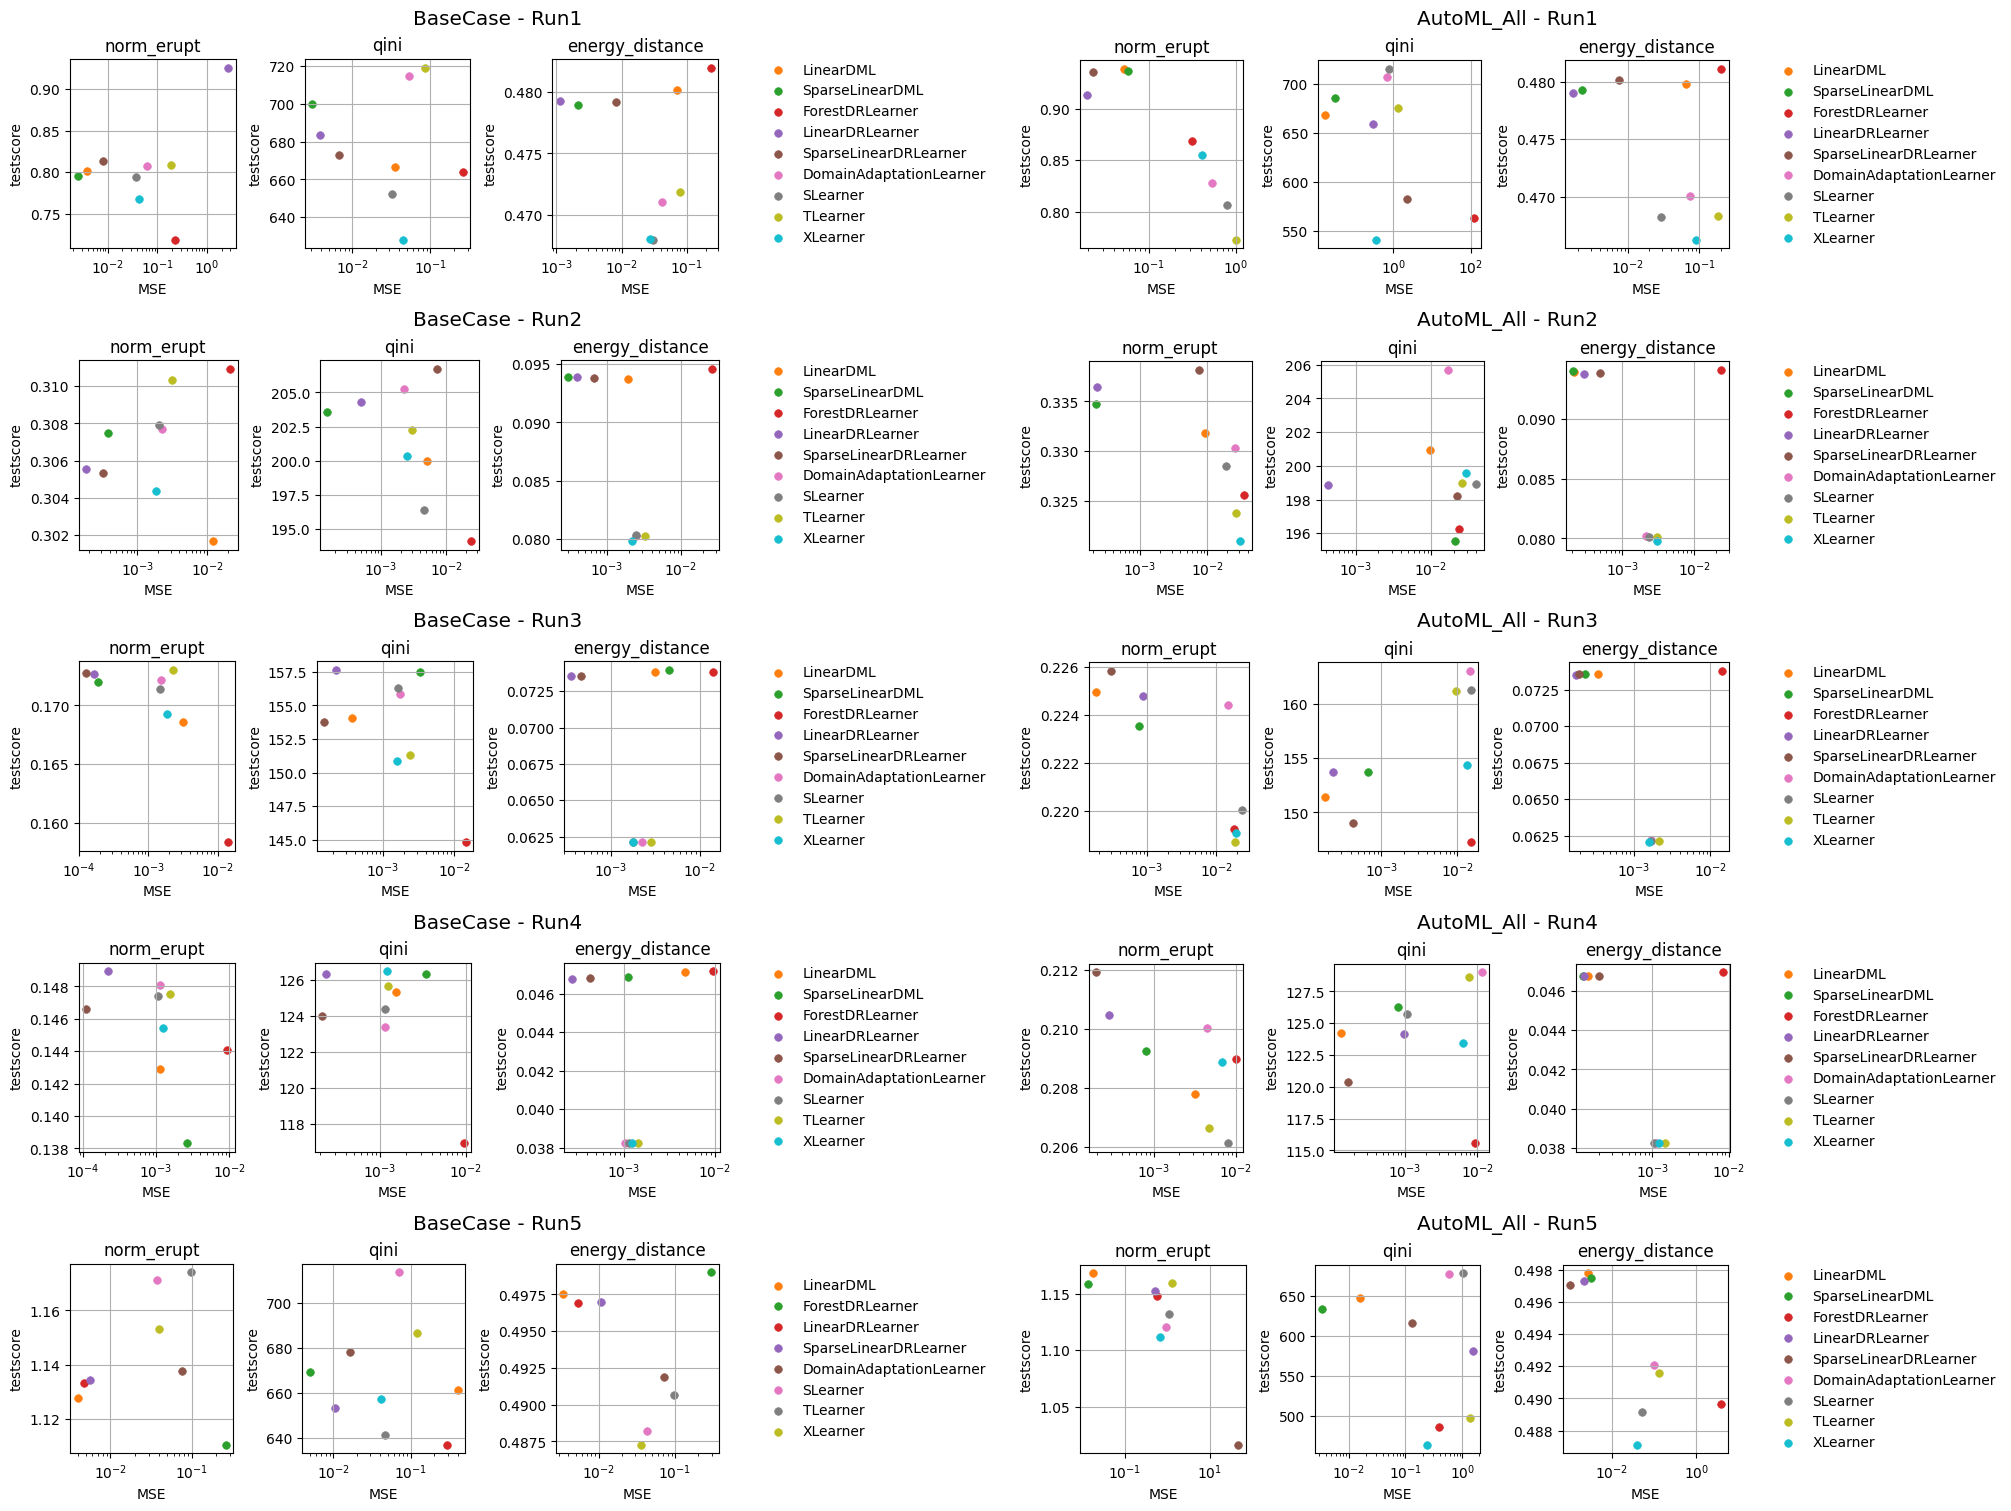

In [5]:

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

# f, axs = plt.subplots(1,len(metrics),)

est_labels = [[], [], []]
#sc = [[], [], []]
fig = plt.figure(constrained_layout=True,figsize=(20, 15))
subfigs = fig.subfigures(1,len(out_dir))#wspace=0.07
for o in range(len(out_dir)):
    subsubfigs=subfigs[o].subfigures(len(subtitle),1)
    for k in range(len(subtitle)):
        #subfigs[o].set_facecolor('0.75')
       
        p=scorelist[model[o]][k]['pr_p'].unique()[0]
        r=scorelist[model[o]][k]['pr_r'].unique()[0]
        t=scorelist[model[o]][k]['pr_t'].unique()[0]
        #Propensity(P:{p:0.3f}, Recall:{r:0.3f}, Threshold:{t:0.3f})
        subsubfigs[k].suptitle(f'{model[o]} - {subtitle[k]} ', fontsize='x-large')
        ax=subsubfigs[k].subplots(1,len(metrics))
        est_labels = [[], [], []]
        for i, metric in enumerate(metrics):
            with open(f"{out_dir[o]}{filename_out}_{metric}_run_{k+1}.pkl","rb") as f:
                results = pickle.load(f)
            
            for (est_name, scr), col in zip(results["scores_per_estimator"].items(),colors): 
                if "Dummy" not in est_name:
                    if len(scr):
                        CATE_gt = scr[0]["test"]["CATE_groundtruth"].values
                        CATE_est = scr[0]["test"]["CATE_estimate"].reshape(-1,)
                        mse=np.mean((CATE_gt-CATE_est)**2)
                        score = scr[0]["test"][metric]
                        ax[i].scatter(mse,score,color=col,s=30,linewidths=0.5)
                        est_labels[i].append(est_name.split(".")[-1])
                    #print(f'{metric} {est_name.split(".")[-1]}, score:{score}')
            ax[i].set_xlabel("MSE")
            ax[i].set_ylabel("testscore")
            ax[i].set_title(metric)
            ax[i].set_xscale("log")  
            #plt.xlim(10**-4.1,10**-2.1)
            ax[i].grid(True)
        plt.legend(est_labels[0],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)
plt.savefig(f'./plot/{model[0]}Vs{model[-1]}_metric_Vs_MSE.png')
        #plt.legend(est_labels[0],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)
        #plt.tight_layout()
    #out=out.replace("/","")
    #out=out.replace(".","")
        #plt.savefig(f"./plot/AutoML_GNB_SVM_DT_LR_MLP_{subtitle[k]}_Metric_vs_MSE.png")

# Exploring the difference on norm_erupt experiment
<font size="4">
As the above result shows that the mertric norm_erupt on extended propensity class outperforming the base case, this section will draw attention to examiated the reason behine.
</font>

## Propensity model for the extended AutoML and Base case

<font size="4">
The following table shows the propensity model and the corresponding hyper-parameters for those 2 cases.

For the extended AutoML experiment, MLP and Logistic Regression is choosen as propensity function while the base case selecting ExtraTree, XGBoost and RandomForest 
   </font>

In [6]:
pd.set_option('display.max_colwidth', 200)
tdf=pd.DataFrame(columns=['Run',f'{model[-1]} propensityModel',f'{model[-1]} Case propensityParam'])
tdf2=pd.DataFrame(columns=['Run',f'{model[0]}  PropensityModel',f'{model[0]}  PropensityParam'])
for i in range(len(subtitle)):
    df=scorelist[f'{model[-1]}'][i]
    df=df[df['metric']=='norm_erupt']
    tdf=pd.concat([tdf,df[['Run','propensityModel','propensityParam']]])
for i in range(len(subtitle)):
    df=scorelist[f'{model[0]}'][i]
    df=df[df['metric']=='norm_erupt']
    tdf2=pd.concat([tdf2,df[['Run','propensityModel','propensityParam']]])
tdf=tdf.groupby('Run',as_index=False)['propensityModel','propensityParam'].agg(['unique'])
tdf2=tdf2.groupby('Run',as_index=False)['propensityModel','propensityParam'].agg(['unique'])
td=pd.concat([tdf,tdf2],axis=1)
td.columns=[f'{model[-1]} propensityModel',f'{model[-1]} propensityParam',f'{model[0]} PropensityModel',f'{model[0]} PropensityParam']
td

,AutoML_All propensityModel,AutoML_All propensityParam,BaseCase PropensityModel,BaseCase PropensityParam
Run,,,,
1,[MLP],"[{'task': 'binary', '_estimator_type': 'classifier', 'hiddenlayer': (100,), 'activation': 'relu', 'alpha': 0.0001}]",[ExtraTreesEstimator],"[{'n_estimators': 37, 'max_features': 0.525128585651986, 'criterion': 'entropy', 'n_jobs': -1, 'max_leaf_nodes': 9, 'verbose': 0, 'task': 'binary', '_estimator_type': 'classifier'}]"
2,[LR],"[{'penalty': 'l1', 'solver': 'saga', 'C': 0.11274012784429405, 'l1_ratio': 0, 'n_jobs': -1, 'task': 'binary', '_estimator_type': 'classifier'}]",[XGBoostSklearnEstimator],"[{'n_estimators': 4, 'max_leaves': 11, 'min_child_weight': 19.551076322837446, 'learning_rate': 0.6812528291885037, 'subsample': 0.9505927261867689, 'colsample_bylevel': 0.8135292538390625, 'colsa..."
3,[LR],"[{'penalty': 'l1', 'solver': 'saga', 'C': 0.0775825676123844, 'l1_ratio': 0.1834680176784576, 'n_jobs': -1, 'task': 'binary', '_estimator_type': 'classifier'}]",[ExtraTreesEstimator],"[{'n_estimators': 100, 'max_features': 0.3902898277472091, 'criterion': 'gini', 'n_jobs': -1, 'max_leaf_nodes': 5, 'verbose': 0, 'task': 'binary', '_estimator_type': 'classifier'}]"
4,[LR],"[{'penalty': 'l1', 'solver': 'saga', 'C': 1.5978799420103134, 'l1_ratio': 0, 'n_jobs': -1, 'task': 'binary', '_estimator_type': 'classifier'}]",[ExtraTreesEstimator],"[{'n_estimators': 29, 'max_features': 0.38178118858401927, 'criterion': 'gini', 'n_jobs': -1, 'max_leaf_nodes': 10, 'verbose': 0, 'task': 'binary', '_estimator_type': 'classifier'}]"
5,[MLP],"[{'hidden_layer_sizes': 70, 'activation': 'tanh', 'alpha': 0.05149871035467862, 'task': 'binary', '_estimator_type': 'classifier', 'hiddenlayer': 70}]",[RandomForestEstimator],"[{'n_estimators': 8, 'max_features': 0.8271942018394663, 'criterion': 'entropy', 'n_jobs': -1, 'max_leaf_nodes': 19, 'verbose': 0, 'task': 'binary', '_estimator_type': 'classifier'}]"


## Propensity model performance 

<font size="4">
As mentioned in the perviouse section, there is believe that propensity model performance is critical in causal influence, let's explore the propensity model performance between base case and the extended one with the prediction and true treatment assigned with PR-Curve. 
</font>

### PR-Curve Comparison

<font size="4">
Since all causal estimators are using the same propensity model that choosen by AutoML, the following plot will only shows one estimator's propensity model result.

The PR-Curve suggested that the extended AutoML performan sigthly better or roughtly the same with the BaseCase. 
However, even the sligthly improvement is unable to explain the difference.
Furthermore, the PR-curve of Run 2 and 3 shows a relatively poor peformance in compare to other's experiment, which confirm with the mixed ranking with low and hight MSE from the above plot. This suggest evidence on a better propensity function is indeed critical. 
    
</font>

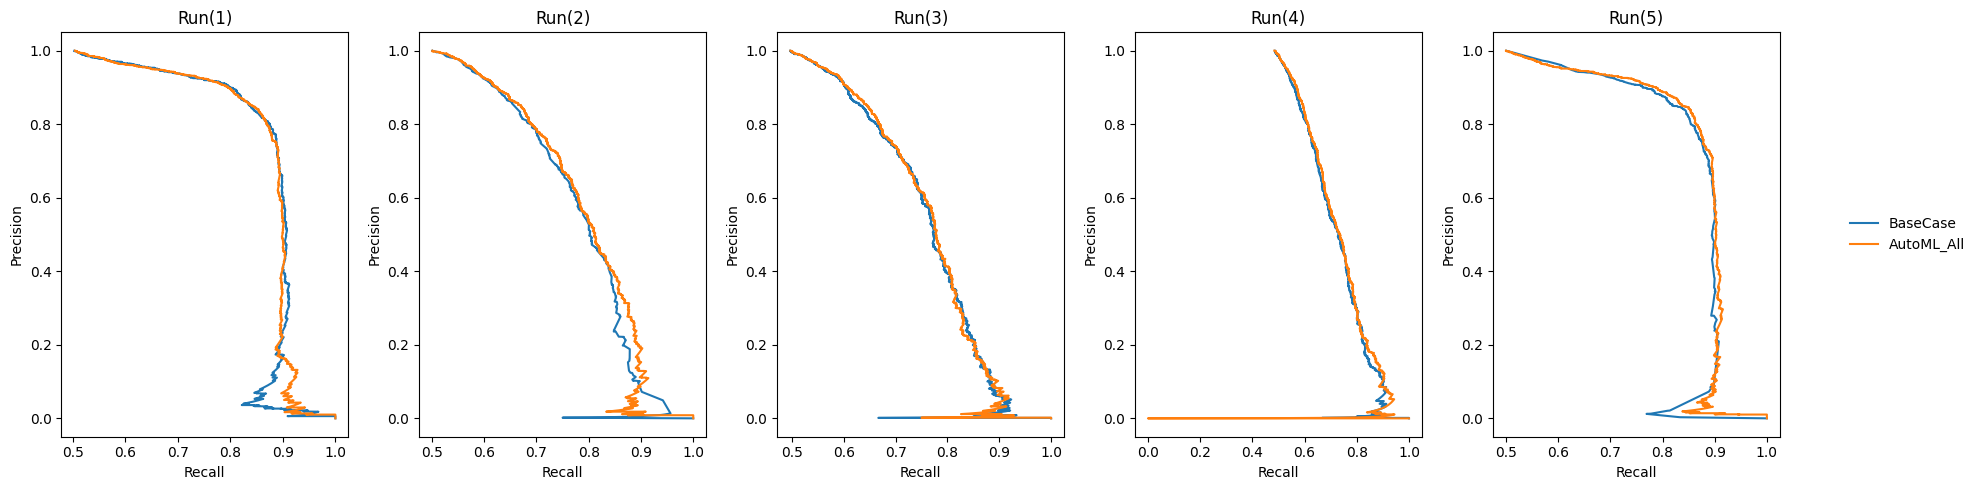

In [7]:
fig,axes=plt.subplots(1,len(subtitle),figsize=(18,5))
for i,ax in enumerate(axes):
    ax.plot(prscore[f'{model[0]}'][f'{i+1}']['norm_erupt'][3][0],prscore[f'{model[0]}'][f'{i+1}']['norm_erupt'][3][1],label='BaseCase')
    ax.plot(prscore[f'{model[-1]}'][f'{i+1}']['norm_erupt'][3][0],prscore[f'{model[-1]}'][f'{i+1}']['norm_erupt'][3][1],label='Extended AutoML')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.set_title(f"Run({i+1})")
    #ax.legend()
plt.tight_layout()
plt.legend([f'{model[0]}',f'{model[-1]}'],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)

### Norm ERUPT Calculation

<font size="4">
Further go deep into the formulation of norm_erupt, the score is calculated by weighted outcome as shows in the following snap 

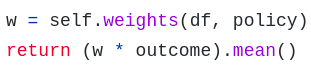

Inaddition, the weight is related to the inverse of propensity score (predict result of propensity model) ie. $w = p^{-1}$

Then, the weight is set to zero if the treatment is not agree on the predefine policy (Causal Estimator Effect prediction > ATE ). 

weight[ (Treatment != (has effect )] = 0.0

So, the weight will only affecting the score iff the causal estimator prediction of effect is agree on Treatment is applied or not.

In result, those poor propensity score (ie. Treatment==1 with p<<1 or Treatment==0 with p>>0 ) will be filter out by the policy which result in small value of the metric.

However it is difficult to examiate the above statement, but it can done by using proxy on the differences between Treatment variable and the Propensity score in order to access how many of the weight will be filter out.
</font>

### Difference between Treatment and Propensity Score 

<font size="4">
From the following boxplot on those 5 runs, it shows that the extended AutoML median is consistenly smaller than the BaseCase and the interquartile range is roughtly tighter except the 2rd Run. The figure suggested that the propensity score of extended AutoML is more closer to the treatment in average which may lead to less filter out on weight.

In addition, the first run of the experiment shows that the extended AutoML is out perform the BaseCase, and if consider together with the first plot of the report, it may suggest that the metric require a very high accuracy prediction in order to work well. 
    </font>

In [8]:
proxypd=pd.DataFrame()
for i in range(len(subtitle)):
    proxypd[f'{model[0]}Run{i+1}']=(values[f'{model[0]}'][f'{i+1}']['norm_erupt'][0]['treated']-values[f'{model[0]}'][f'{i+1}']['norm_erupt'][0]['p'])
    proxypd[f'{model[-1]}Run{i+1}']=(values[f'{model[-1]}'][f'{i+1}']['norm_erupt'][0]['treated']-values[f'{model[-1]}'][f'{i+1}']['norm_erupt'][0]['p'])
    #proxypd[f'BaseCaseRun{i+1}']=values['BaseCase'][f'{i+1}']['norm_erupt'][0]['weights']
    #proxypd[f'ExtendRun{i+1}']=values['AutoML_All'][f'{i+1}']['norm_erupt'][0]['weights']

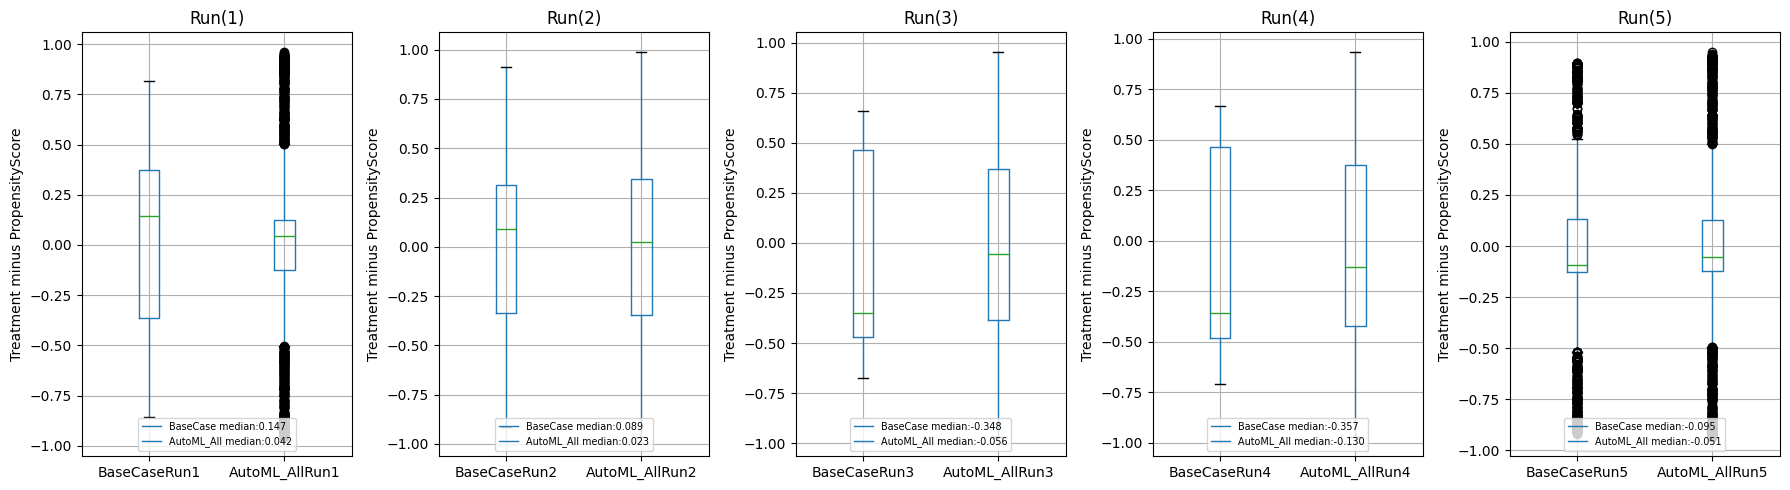

In [9]:
fig,axes=plt.subplots(1,len(subtitle),figsize=(18,5))
for i,ax in enumerate(axes):
    ax.set_title(f'Run({i+1})')
    ax.set_ylabel('Treatment minus PropensityScore')
    bm=proxypd[f'{model[0]}Run{i+1}'].median()
    em=proxypd[f'{model[-1]}Run{i+1}'].median()
    proxypd[[f'{model[0]}Run{i+1}',f'{model[-1]}Run{i+1}']].boxplot(ax=ax)
    ax.legend([f'{model[0]} median:{bm:1.3f}',f'{model[-1]} median:{em:1.3f}'],loc='lower center',fontsize='x-small')
plt.tight_layout()

# Conclusion
<font size="4">
In Conclusion, the project shows some evidence to support the norm ERUPT metric would work in ranking estimator's performance with wider propensity function selection. In addition, it is suspected that the metirc require a very high accuracy on the propensity score predication in order to perform well as shows in the boxplot.
    
</font>

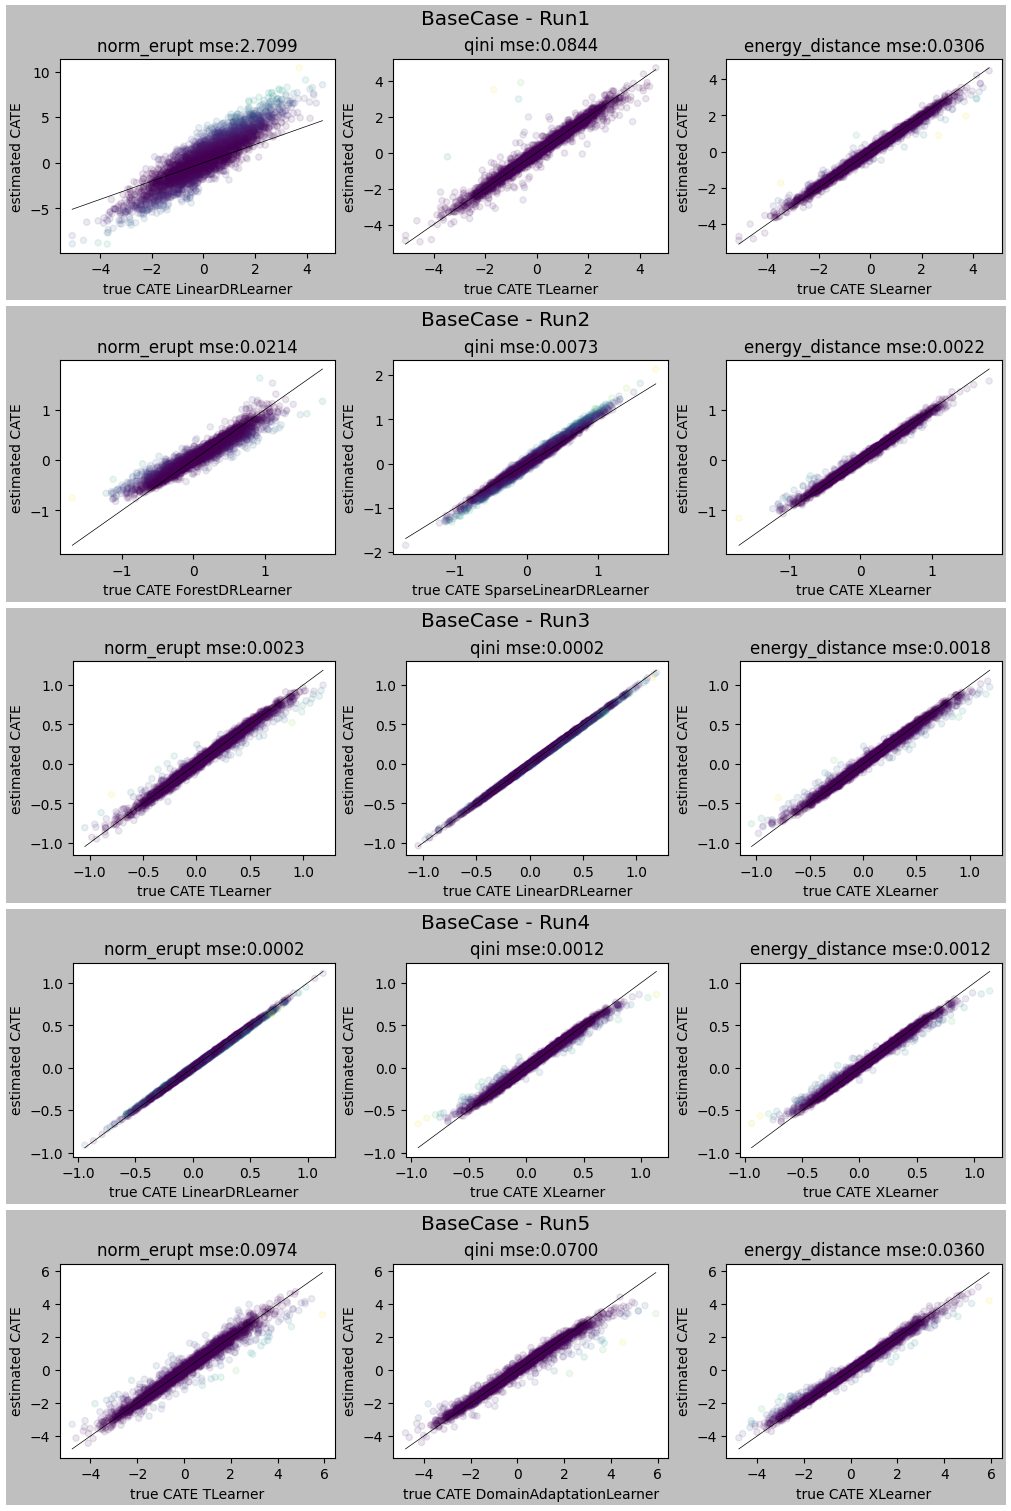

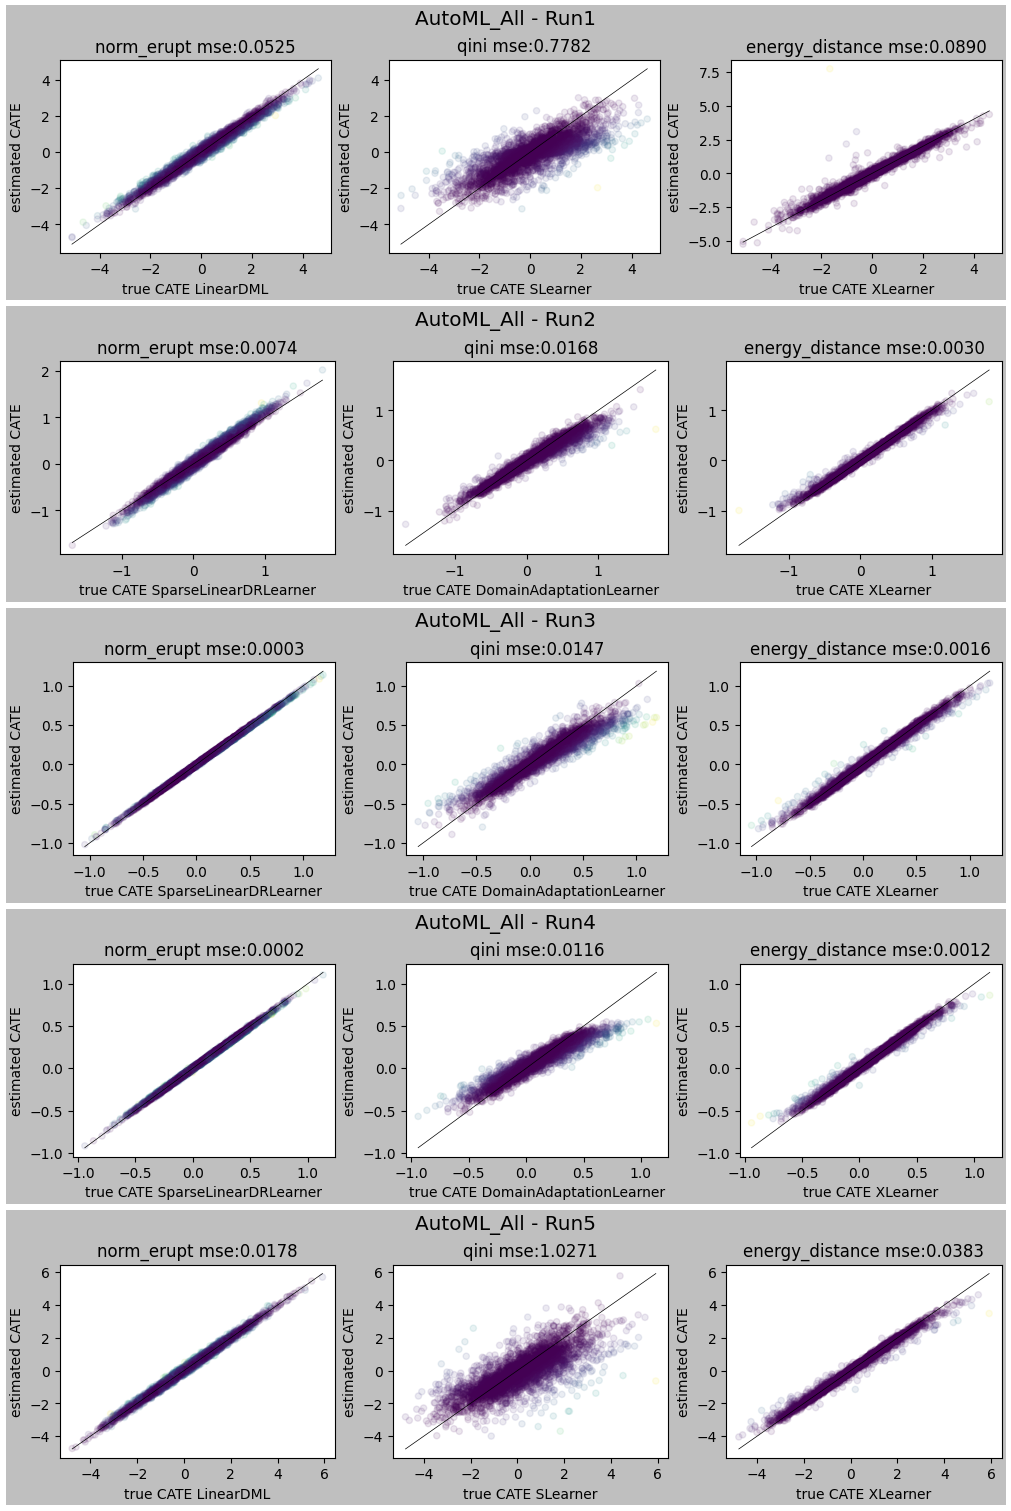

In [10]:
%matplotlib inline
## MSE plot

for i in range(len(out_dir)):
    fig = plt.figure(constrained_layout=True, figsize=(10, 15))
    subfigs = fig.subfigures(len(subtitle),1)#wspace=0.07
    for j in range(len(subtitle)):
        subfigs[j].suptitle(f'{model[i]} - {subtitle[j]}', fontsize='x-large')
        subfigs[j].set_facecolor('0.75')
        ax=subfigs[j].subplots(1,len(metrics))
        for k in range(len(metrics)):
            df=scorelist[model[i]][j]
            if(metrics[k]=="energy_distance"):
                best=df[df['metric']==metrics[k]].sort_values('score').iloc[0,0]
            else:
                best=df[df['metric']==metrics[k]].sort_values('score',ascending=False).iloc[0,0]
            try:
                with open(f"{out_dir[i]}{filename_out}_{metrics[k]}_run_{j+1}.pkl","rb") as f:
                    results = pickle.load(f)
                results["best_estimator"]=best
                CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"].values
                CATE_est = np.array(results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]).reshape(-1,)
                #print(CATE_est.shape)
                #print(CATE_gt.shape)
                e=((CATE_est-CATE_gt)**2)
                mse=np.mean((CATE_gt-CATE_est)**2)
                ax[k].scatter(CATE_gt,CATE_est,s=20,alpha=0.1,c=e,cmap='viridis')          
                ax[k].plot([min(CATE_gt),max(CATE_gt)],[min(CATE_gt),max(CATE_gt)],"k-",linewidth=0.5)
                ax[k].set_xlabel(f"true CATE {results['best_estimator'].split('.')[-1]}")
                ax[k].set_ylabel("estimated CATE")
                ax[k].set_title(f"{results['optimised_metric']} mse:{mse:1.4f}")
               
            except(e):
                print(f"here {e}")
                pass
    plt.savefig(f'./plot/{model[i]}_MSE.png')